# Load files and images

In [38]:
import json

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from scipy.ndimage import gaussian_filter
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [2]:
# DIRECTORIES
annotations_dir_train = './annotations/person_keypoints_train2017.json'
images_dir_train = './train2017/'

annotations_dir_val = './annotations/person_keypoints_val2017.json'
images_dir_val = './val2017/'

In [3]:
# Read the json file and extract the annotations data for all images
def read_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

json_train_data = read_json(annotations_dir_train)
json_validation_data = read_json(annotations_dir_val)

In [4]:
json_train_data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [5]:
# SET GPU AS DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Clean train data
clean_annotations = []
for each_annot in json_train_data['annotations']:
    # Checks if the picture shows more than one person
    if each_annot['iscrowd'] != 0:
        continue
    # Checks if the picture has annotations
    if each_annot['num_keypoints'] < 1:
        continue
        
    # Check if the picture has a big enough box
    if each_annot['bbox'][2] < 48 and each_annot['bbox'][3] < 64:
        continue
        
    clean_annotations.append(each_annot)  

In [7]:
print("Total entries in original data: {}".format(len(json_train_data['annotations'])))
print("Total entries in cleaned data: {}".format(len(clean_annotations)))

Total entries in original data: 262465
Total entries in cleaned data: 144577


# Transforms

Original image shape: (640, 480)
Resized image shape: 147456
Image as array: (256, 192, 3)
Final tensor shape:torch.Size([3, 256, 192]) min:-2.12 max:2.64


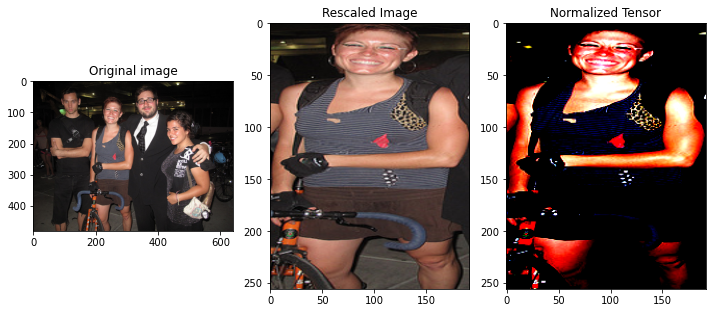

In [8]:
annotation = clean_annotations[1000]
img_name = '000000000000'
img_name = img_name[0:len(img_name) - len(str(annotation['image_id']))] + str(annotation['image_id']) + '.jpg'
pil_image = Image.open(images_dir_train + '/' + img_name)

x, y, w, h = annotation['bbox']
resized_img = pil_image.resize((192, 256), box=(x, y, x + w, y + h))

array = np.array(resized_img)

# Add on more dimension in case image is Black & White
if len(array.shape) != 3:
    array = np.stack((array, )*3, axis=-1)
#     array = np.atleast_3d(array)



transformations = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
rescaled_img = array / 255.
tensor_image = transformations(rescaled_img)


print("Original image shape: {}".format(pil_image.size))
print("Resized image shape: {}".format(rescaled_img.size))
print("Image as array: {}".format(array.shape))
print("Final tensor shape:{} min:{:.2f} max:{:.2f}".format(tensor_image.shape, tensor_image.min(), tensor_image.max()))


fig, ax = plt.subplots(ncols=3, figsize=(10,5))
ax[0].imshow(np.array(pil_image))
ax[0].set_title("Original image")

ax[1].imshow(array)
ax[1].set_title("Rescaled Image")

ax[2].imshow(np.clip(tensor_image.permute(1,2,0).numpy(), 0, 1))
ax[2].set_title("Normalized Tensor")

plt.tight_layout()
plt.show()

# Heatmaps

In [9]:
keypoints_names = json_train_data['categories'][0]['keypoints']
keypoints = np.array(annotation['keypoints']).reshape(17,3)
keypoints_dict = {name: k for (name, k) in zip(keypoints_names, keypoints)}

In [10]:
keypoints_dict

{'nose': array([248, 106,   2]),
 'left_eye': array([263,  93,   2]),
 'right_eye': array([241,  89,   2]),
 'left_ear': array([278, 104,   2]),
 'right_ear': array([226,  96,   2]),
 'left_shoulder': array([293, 167,   2]),
 'right_shoulder': array([204, 168,   2]),
 'left_elbow': array([307, 271,   2]),
 'right_elbow': array([192, 253,   2]),
 'left_wrist': array([227, 273,   2]),
 'right_wrist': array([189, 317,   2]),
 'left_hip': array([279, 306,   2]),
 'right_hip': array([222, 307,   2]),
 'left_knee': array([299, 429,   2]),
 'right_knee': array([222, 443,   2]),
 'left_ankle': array([0, 0, 0]),
 'right_ankle': array([0, 0, 0])}

In [11]:
heatmap_w = 48
heatmap_h = 64
rescaled_keypoints = np.ceil((keypoints - [x, y, 0]) * (np.array([heatmap_w, heatmap_h, 1]) / np.array([w, h, 1])) ).astype(np.int)

In [12]:
rescaled_keypoints

array([[ 23,   8,   2],
       [ 28,   6,   2],
       [ 21,   6,   2],
       [ 33,   8,   2],
       [ 16,   7,   2],
       [ 38,  17,   2],
       [  8,  18,   2],
       [ 43,  33,   2],
       [  4,  31,   2],
       [ 16,  34,   2],
       [  3,  40,   2],
       [ 33,  39,   2],
       [ 14,  39,   2],
       [ 40,  58,   2],
       [ 14,  60,   2],
       [-61,  -8,   0],
       [-61,  -8,   0]])

In [13]:
heatmaps = np.zeros((17, 64, 48))
for i in range(17):
    if rescaled_keypoints[i][2] > 0:
        temp_x = rescaled_keypoints[i][1]
        temp_y = rescaled_keypoints[i][0]
        heatmaps[i, temp_x, temp_y] = 1.0
        heatmaps[i, :, :] = gaussian_filter(heatmaps[i, :, :], sigma=2, mode='constant', cval=0.0)
        heatmaps[i, :, :] = (heatmaps[i, :, :] - np.min(heatmaps[i, :, :])) / (np.max(heatmaps[i, :,:]) - np.min(heatmaps[i, :, :]))
        
validity = [1 if v > 0 else 0 for v in rescaled_keypoints[:,2]]   


validity_tensor = torch.tensor(validity).float()
heatmaps_tensor = torch.tensor(heatmaps).float()

# MAKE THE CLASS

In [84]:
# =============================================================================
# DATASET CLASS
# =============================================================================
class AnnotationsDataset(Dataset):

    def __init__(self, annotations_path, img_dir):
        self.annotations_path = annotations_path
        self.img_dir = img_dir
        self.data = self.read_json(self.annotations_path)
        self.annotations = self.data['annotations']
        self.keypoint_names = self.data['categories'][0]['keypoints']
        # Clean annotations
        self.clean_annotations = self.clean_data(data=self.data)
        
    def read_json(self, path):
        """
        Reads a json file and returns the data

        Parameters:
            path (string) : path to json file

        Returns:
            data (dict) : Dictionary from json file
        """
        with open(path, 'r') as f:
            data = json.load(f)
        return data
        
    def clean_data(self, data):
        """
        Clean the data from images with small boundary boxes or with no annotations

        Parameters:
            data  : orginal annotation data

        Returns:
            clean_annotations : cleaned annotations
        """
        clean_annotations = []
        for each_annot in data['annotations']:
            # Checks if the picture shows more than one person
            if each_annot['iscrowd'] != 0:
                continue
            # Checks if the picture has annotations
            if each_annot['num_keypoints'] < 1:
                continue

            # Check if the picture has a big enough box
            if each_annot['bbox'][2] < 48 and each_annot['bbox'][3] < 64:
                continue

            clean_annotations.append(each_annot)  

        return clean_annotations



    def load_image(self, annotation):
        """
        Loads an image, apply transforms (rescale, resize, normalize, transformed to tensor)

        Parameters:
            annotation  : Image's annotations

        Returns:
            tensor_image : Image in tensor form, normalized, resized(192 x 256), rescaled(0...1)
        """
        img_name = '000000000000'
        img_name = img_name[0:len(img_name) - len(str(annotation['image_id']))] + str(annotation['image_id']) + '.jpg'
        pil_image = Image.open(self.img_dir + '/' + img_name)

        x, y, w, h = annotation['bbox']
        resized_img = pil_image.resize((192, 256), box=(x, y, x + w, y + h))

        array = np.array(resized_img)

        # Add on more dimension in case image is Black & White
        if len(array.shape) != 3:
            array = np.stack((array, )*3, axis=-1)
        #     array = np.atleast_3d(array)

        transformations = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])])
        rescaled_img = array / 255.
        tensor_image = transformations(rescaled_img)
        
        return tensor_image

   
    def heatmaps(self, annotation):
        """
        Creates heatmaps for an image

        Parameters:
            annotation  : Image's annotations

        Returns:
            heatmaps_tensor : Heatmaps in tensor form, shape(17, 64, 48)
            validity_tensor : Tensor with all valid keypoints, shape (17,)
        """
        
        keypoints = np.array(annotation['keypoints']).reshape(17,3)
        x, y, w, h = annotation['bbox']
        heatmap_w = 48
        heatmap_h = 64
        original_w = 192
        orginal_h = 256
        rescaled_keypoints = np.ceil((keypoints - [x, y, 0]) * (np.array([heatmap_w, heatmap_h, 1]) / np.array([w, h, 1])) ).astype(np.int)
        
        heatmaps = np.zeros((17, 64, 48))
        for i in range(17):
            if rescaled_keypoints[i][2] > 0:
                
                temp_x = rescaled_keypoints[i][1]
                temp_y = rescaled_keypoints[i][0]
                
                if temp_x>=64 or temp_y>=48:
                    continue
                    rescaled_keypoints[i][2] = 0
                else:
                    heatmaps[i, temp_x, temp_y] = 1.0
                    heatmaps[i, :, :] = gaussian_filter(heatmaps[i, :, :], sigma=2, mode='constant', cval=0.0)
                    heatmaps[i, :, :] = (heatmaps[i, :, :] - np.min(heatmaps[i, :, :])) / (np.max(heatmaps[i, :,:]) - np.min(heatmaps[i, :, :]))
                
        validity = [1 if v > 0 else 0 for v in rescaled_keypoints[:,2]]   


        validity_tensor = torch.tensor(validity).float()
        heatmaps_tensor = torch.tensor(heatmaps).float()
        
        return heatmaps_tensor, validity_tensor

    
    def __len__(self):
        return len(self.clean_annotations)

    def __getitem__(self, id):
        annotation = self.annotations[id]
        image = self.load_image(annotation)
        heatmap, validity = self.heatmaps(annotation)
        
        return {'image': image, 'heatmap': heatmap, 'validity': validity}

In [87]:
# initialize Datasets
train_dataset = AnnotationsDataset(annotations_path='./annotations/person_keypoints_train2017.json',
                                   img_dir='./train2017')
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

val_dataset = AnnotationsDataset(annotations_path='./annotations/person_keypoints_val2017.json', img_dir='./val2017')
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0)

In [89]:
sample = next(iter(train_dataloader))